# Find timing of shake cues from Synch Audio (syncspider)

Notebook to extract shaker table hits from audio recordings to correct for sensor clock offsets and drift. 

In [61]:
import sys
import os
import time
import datetime as dt
import math
import numpy as np 
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import librosa
from IPython.display import Audio
import mir_eval.sonify


from scipy.signal import butter, filtfilt, argrelextrema
from scipy import interpolate
from scipy.interpolate import interp1d

In [62]:
pip show librosa | grep Version

Version: 0.10.1
Note: you may need to restart the kernel to use updated packages.


In [63]:
pip show numpy | grep Version

Version: 1.25.2
Note: you may need to restart the kernel to use updated packages.


In [64]:
def local_max_max(cue,cue_delay,thresh = 0.99):
    rms =librosa.feature.rms(y=cue, frame_length=256, hop_length=64, center=True, pad_mode='constant')
    times = librosa.times_like(rms,sr = sr, hop_length=64)
    rms_sf = int(sr/64)
    cue_df = pd.DataFrame(index = times+cue_delay)
    cue_df['rms'] = rms[0]
    cue_df['peaks'] = 0
    a = cue_df['rms'].copy()
    a[a< a.quantile(thresh)] = 0
    peaks =pd.Series(sp.signal.find_peaks(a)[0])#, height = 300, threshold = None, distance=10

    j = 0
    while j <len(peaks):
        seg = peaks.loc[(peaks-peaks[j]).abs()<(rms_sf/2)].copy()
        if len(seg)>1:
            j = seg.index[-1]
            peak_j = a.iloc[seg.values].idxmax()
        else:
            peak_j = a.index[peaks[j]]
        cue_df.loc[peak_j,'peaks'] = 1
        j+=1

    return cue_df

In [70]:
# from audio around sync 1 7:58
# from Equivital clocks (approx) 6:57:31
sync_start = pd.to_datetime('2024-03-07 06:57:29.000+0000') # 
#pd.to_timedelta(Piece_timings.loc[:,c],unit='s')
sync_start

Timestamp('2024-03-07 06:57:29+0000', tz='UTC')

In [88]:
data_dir='/Volumes/SeagateHub/BiC2024/20240307/' 
audio_file =data_dir+'SyncSpider/ZOOM0001_LR-0001.WAV'
y, sr = librosa.load(audio_file)
file1_len = len(y)

In [89]:
cue_delay = 19 # seconds
cue_start = cue_delay*sr
cue_end = cue_start + 9*sr
cue = y[cue_start:cue_end]
len(cue)

198450

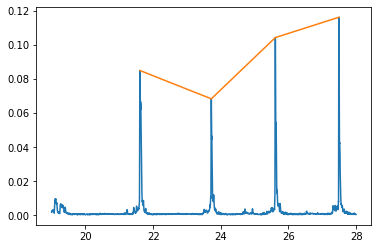

In [90]:
cue_df = local_max_max(cue,np.round(cue_delay,3))
cue_df#.sum()
cue_df['rms'].plot()
cue_df.loc[cue_df['peaks']==1,'rms'].plot()
plt.show()

In [91]:
cue_df.index

Index([              19.0, 19.002902494331067,  19.00580498866213,
         19.0087074829932, 19.011609977324262,  19.01451247165533,
       19.017414965986394,  19.02031746031746, 19.023219954648525,
       19.026122448979592,
       ...
       27.971609977324263,  27.97451247165533, 27.977414965986394,
        27.98031746031746, 27.983219954648526, 27.986122448979593,
       27.989024943310657, 27.991927437641724, 27.994829931972788,
       27.997732426303855],
      dtype='float64', length=3101)

In [92]:
cue_df['DateTime'] = sync_start + pd.to_timedelta(cue_df.index,unit='s')
cue_df

,rms,peaks,DateTime
19.000000,0.001762,0,2024-03-07 06:57:48+00:00
19.002902,0.002293,0,2024-03-07 06:57:48.002902494+00:00
19.005805,0.002601,0,2024-03-07 06:57:48.005804989+00:00
19.008707,0.002775,0,2024-03-07 06:57:48.008707483+00:00
19.011610,0.002708,0,2024-03-07 06:57:48.011609977+00:00
...,...,...,...
27.986122,0.000558,0,2024-03-07 06:57:56.986122449+00:00
27.989025,0.000583,0,2024-03-07 06:57:56.989024943+00:00
27.991927,0.000620,0,2024-03-07 06:57:56.991927438+00:00
27.994830,0.000527,0,2024-03-07 06:57:56.994829932+00:00


In [80]:
cue_df.to_csv('./outfiles/cue1_20240307.csv')

In [81]:
data_dir='/Volumes/SeagateHub/BiC2024/20240307/' 
audio_file =data_dir+'SyncSpider/ZOOM0001_LR-0002.WAV'
y, sr = librosa.load(audio_file)
file2_len = len(y)

In [82]:
print(file2_len/sr)
cue_delay = np.round(-43 + (file2_len/sr),0) # seconds
cue_start = int(cue_delay*sr)
cue_end = np.min([cue_start + 8*sr,file2_len])
cue = y[cue_start:cue_end]
len(cue)

6951.870113378684


176400

In [83]:
Audio(data=cue, rate=sr)

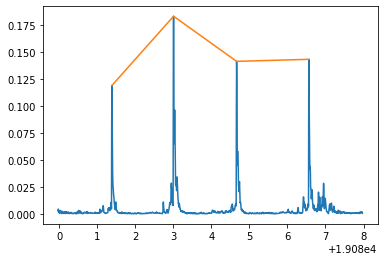

rms      13.445981
peaks     4.000000
dtype: float64

In [84]:
cue_df = local_max_max(cue,np.round(cue_delay+(file1_len/sr),3))
cue_df#.sum()
cue_df['rms'].plot()
cue_df.loc[cue_df['peaks']==1,'rms'].plot()
plt.show()
cue_df.sum()

In [85]:
cue_df['DateTime'] = sync_start + pd.to_timedelta(cue_df.index,unit='s')

In [86]:
cue_df

,rms,peaks,DateTime
19079.971000,0.002945,0,2024-03-07 12:15:28.971000+00:00
19079.973902,0.004152,0,2024-03-07 12:15:28.973902494+00:00
19079.976805,0.004743,0,2024-03-07 12:15:28.976804989+00:00
19079.979707,0.004667,0,2024-03-07 12:15:28.979707483+00:00
19079.982610,0.004037,0,2024-03-07 12:15:28.982609977+00:00
...,...,...,...
19087.958664,0.001857,0,2024-03-07 12:15:36.958664399+00:00
19087.961567,0.001464,0,2024-03-07 12:15:36.961566893+00:00
19087.964469,0.001421,0,2024-03-07 12:15:36.964469388+00:00
19087.967372,0.001190,0,2024-03-07 12:15:36.967371882+00:00


In [87]:
cue_df.to_csv('./outfiles/cue2_20240307.csv')

# back to Monday 2024 03 04

In [163]:
data_dir='/Volumes/SeagateHub/BiC2024/20240304/' 
audio_file =data_dir+'/Audio/SyncSpider/FOLDER01/ZOOM0001/ZOOM0001_LR-0001.WAV'
y, sr = librosa.load(audio_file)
file1_len = len(y)
print(file1_len/sr)

23624.630566893426


In [164]:
23624/3600

6.562222222222222

In [165]:
cue_delay = 285.4 # seconds
cue_start = int(cue_delay*sr)
cue_end = cue_start + 6*sr
cue = y[cue_start:cue_end]
len(cue)

132300

In [166]:
Audio(data=cue, rate=sr)

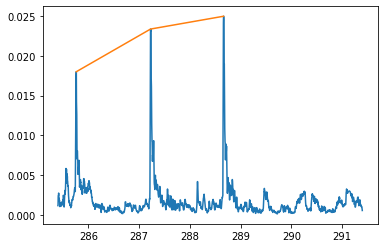

In [167]:

cue_df = local_max_max(cue,np.round(cue_delay,3),thresh = 0.98)
cue_df#.sum()
cue_df['rms'].plot()
cue_df.loc[cue_df['peaks']==1,'rms'].plot()
plt.show()

In [168]:
cue_df.index[cue_df['peaks']==1].diff()

Index([nan, 1.4628571428571604, 1.4396371882086214], dtype='float64')

In [169]:
cue_df.index[cue_df['peaks']==1]

Index([285.76281179138317, 287.22566893424033, 288.66530612244895], dtype='float64')

In [170]:
# from audio around sync 1
# don't actually know, might be worth correcting later
# but we were ready for musicians by 09:00 UTC+1 
# and their rehearsal ended at 14:00+1 or 1300+1
# and the recording was 6 and a half hours long so 
# this shoudl be around the right duration.
# or
# 3 hrs and 22 minutes before 12:14 is 8:52 UTC+1 or 7:52 UTC+0
sync_start = pd.to_datetime('2024-03-04 07:51:38.000+0000') # 06:33:45 until audio shut off, before second  cue

#pd.to_timedelta(Piece_timings.loc[:,c],unit='s')
sync_start

Timestamp('2024-03-04 07:51:38+0000', tz='UTC')

In [171]:
cue_df['DateTime'] = sync_start + pd.to_timedelta(cue_df.index,unit='s')

In [172]:
cue_df

,rms,peaks,DateTime
285.400000,0.001170,0,2024-03-04 07:56:23.400000+00:00
285.402902,0.001286,0,2024-03-04 07:56:23.402902494+00:00
285.405805,0.002300,0,2024-03-04 07:56:23.405804989+00:00
285.408707,0.002432,0,2024-03-04 07:56:23.408707483+00:00
285.411610,0.002427,0,2024-03-04 07:56:23.411609977+00:00
...,...,...,...
291.387846,0.001048,0,2024-03-04 07:56:29.387845805+00:00
291.390748,0.000964,0,2024-03-04 07:56:29.390748299+00:00
291.393651,0.000920,0,2024-03-04 07:56:29.393650794+00:00
291.396553,0.000736,0,2024-03-04 07:56:29.396553288+00:00


In [173]:
cue_df.to_csv('./outfiles/cue1_20240304.csv')

No apparent recorded second cue for monday. Maybe the spider got shut off by accident.

# Tuesday 24 03 05

It looks like there were three cues used on Tuesday, with a few sensors processed late



In [50]:
data_dir='/Volumes/SeagateHub/BiC2024/20240305/' 
audio_file =data_dir+'/SyncSpider/ZOOM0001/ZOOM0001_LR-0001.WAV'
y, sr = librosa.load(audio_file)
file1_len = len(y)
print(file1_len/sr)

12170.971428571429


In [51]:
(12170.971428571429-3*3600)/60
# 3 hrs and 22 minutes before 12:04 is 8:42 UTC+1 or 7:42 UTC+0

22.849523809523816

In [52]:
cue_delay = 4 # seconds
cue_start = int(cue_delay*sr)
cue_end = cue_start + 10*sr
cue = y[cue_start:cue_end]
len(cue)

220500

In [53]:
cue_delay

4

In [54]:
Audio(data=cue, rate=sr)

In [55]:
# 3 hrs and 22 minutes before 12:04 is 8:42 UTC+1 or 7:42 UTC+0
sync_start = pd.to_datetime('2024-03-05 07:42:14.000+0000')
#pd.to_timedelta(Piece_timings.loc[:,c],unit='s')
sync_start

Timestamp('2024-03-05 07:42:14+0000', tz='UTC')

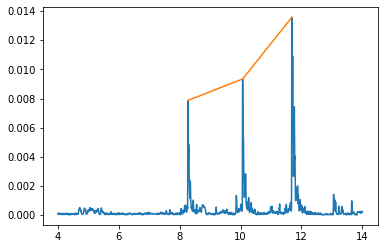

In [56]:
cue_df = local_max_max(cue,np.round(cue_delay,3))
cue_df#.sum()
cue_df['rms'].plot()
cue_df.loc[cue_df['peaks']==1,'rms'].plot()
plt.show()

In [57]:
cue_df['DateTime'] = sync_start + pd.to_timedelta(cue_df.index,unit='s')

In [58]:
cue_df.to_csv('./outfiles/cue1_20240305.csv')
cue_df

,rms,peaks,DateTime
4.000000,0.000088,0,2024-03-05 07:42:18+00:00
4.002902,0.000102,0,2024-03-05 07:42:18.002902494+00:00
4.005805,0.000125,0,2024-03-05 07:42:18.005804989+00:00
4.008707,0.000131,0,2024-03-05 07:42:18.008707483+00:00
4.011610,0.000114,0,2024-03-05 07:42:18.011609977+00:00
...,...,...,...
13.987483,0.000248,0,2024-03-05 07:42:27.987482993+00:00
13.990385,0.000243,0,2024-03-05 07:42:27.990385488+00:00
13.993288,0.000258,0,2024-03-05 07:42:27.993287982+00:00
13.996190,0.000252,0,2024-03-05 07:42:27.996190476+00:00


In [36]:
data_dir='/Volumes/SeagateHub/BiC2024/20240305/' 
audio_file =data_dir+'/SyncSpider/ZOOM0001/ZOOM0001_LR-0002.WAV'
y, sr = librosa.load(audio_file)
file2_len = len(y)
print(file2_len/sr)

12170.971428571429


In [37]:
cue_delay = np.round(10073.5,0) # seconds
cue_start = int(cue_delay*sr)
cue_end = np.min([cue_start + 6*sr,file2_len])
cue = y[cue_start:cue_end]
len(cue)

132300

In [38]:
Audio(data=cue, rate=sr)

In [39]:
cue_start 

222131700

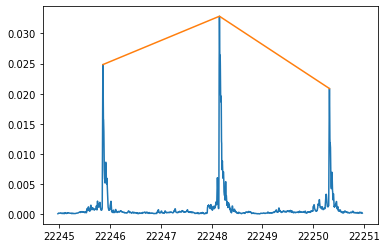

rms      2.184968
peaks    3.000000
dtype: float64

In [40]:
cue_df = local_max_max(cue,np.round(cue_delay+1*(file1_len/sr),3))
cue_df#.sum()
cue_df['rms'].plot()
cue_df.loc[cue_df['peaks']==1,'rms'].plot()
plt.show()
cue_df.sum()

In [41]:
cue_df['DateTime'] = sync_start + pd.to_timedelta(cue_df.index,unit='s')
cue_df

,rms,peaks,DateTime
22244.971000,0.000078,0,2024-03-05 13:52:58.971000+00:00
22244.973902,0.000107,0,2024-03-05 13:52:58.973902494+00:00
22244.976805,0.000134,0,2024-03-05 13:52:58.976804989+00:00
22244.979707,0.000161,0,2024-03-05 13:52:58.979707483+00:00
22244.982610,0.000169,0,2024-03-05 13:52:58.982609977+00:00
...,...,...,...
22250.958846,0.000282,0,2024-03-05 13:53:04.958845805+00:00
22250.961748,0.000275,0,2024-03-05 13:53:04.961748299+00:00
22250.964651,0.000270,0,2024-03-05 13:53:04.964650794+00:00
22250.967553,0.000206,0,2024-03-05 13:53:04.967553288+00:00


In [42]:
cue_df.to_csv('./outfiles/cue2_20240305.csv')

In [43]:
data_dir='/Volumes/SeagateHub/BiC2024/20240305/' 
audio_file =data_dir+'/SyncSpider/ZOOM0001/ZOOM0001_LR-0003.WAV'
y, sr = librosa.load(audio_file)
file3_len = len(y)
print(file3_len/sr)

3771.8915192743766


In [44]:
cue_delay = np.round(-35 + (file3_len/sr),0) # seconds
cue_start = int(cue_delay*sr)
cue_end = np.min([cue_start + 6*sr,file3_len])
cue = y[cue_start:cue_end]
len(cue)

132300

In [45]:
cue_start 

82400850

In [46]:
Audio(data=cue, rate=sr)

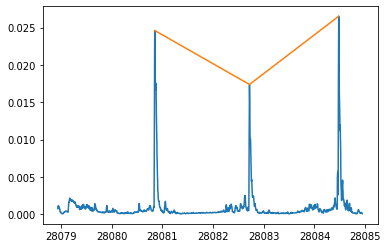

rms      1.906084
peaks    3.000000
dtype: float64

In [47]:
cue_df = local_max_max(cue,np.round(cue_delay+2*(file1_len/sr),3))
cue_df#.sum()
cue_df['rms'].plot()
cue_df.loc[cue_df['peaks']==1,'rms'].plot()
plt.show()
cue_df.sum()

In [48]:
cue_df['DateTime'] = sync_start + pd.to_timedelta(cue_df.index,unit='s')
cue_df

,rms,peaks,DateTime
28078.943000,0.000738,0,2024-03-05 15:30:12.943000+00:00
28078.945902,0.001066,0,2024-03-05 15:30:12.945902494+00:00
28078.948805,0.001135,0,2024-03-05 15:30:12.948804989+00:00
28078.951707,0.001135,0,2024-03-05 15:30:12.951707483+00:00
28078.954610,0.001138,0,2024-03-05 15:30:12.954609977+00:00
...,...,...,...
28084.930846,0.000173,0,2024-03-05 15:30:18.930845805+00:00
28084.933748,0.000137,0,2024-03-05 15:30:18.933748299+00:00
28084.936651,0.000095,0,2024-03-05 15:30:18.936650794+00:00
28084.939553,0.000084,0,2024-03-05 15:30:18.939553288+00:00


In [49]:
cue_df.to_csv('./outfiles/cue3_20240305.csv')

In [ ]:
# RD tuning 10539.875

# Not Synch cues in audio for Wednesday

In [ ]:
# C1 tuning ?
# C2 tuning ?

# Synch cues for Thursday 240307

In [ ]:
data_dir='/Volumes/SeagateHub/BiC2024/20240307/' 
audio_file =data_dir+'/SyncSpider/ZOOM0001_LR-0001.WAV'
y, sr = librosa.load(audio_file)
file1_len = len(y)
print(file1_len/sr)

In [ ]:
# 3 hrs and 22 minutes before 11:19 is 7:57 UTC+1 or 6:57 UTC+0
# confirmed in audio for sync cue 1 at 7:58 UTC+1
sync_start = pd.to_datetime('2024-03-07 06:57:00.000+0000')
sync_start

In [ ]:
cue_delay = 20 # seconds
cue_start = int(cue_delay*sr)
cue_end = cue_start + 8*sr
cue = y[cue_start:cue_end]
print(len(cue))
Audio(data=cue, rate=sr)

In [ ]:
cue_df = local_max_max(cue,np.round(cue_delay,3))
cue_df#.sum()
cue_df['rms'].plot()
cue_df.loc[cue_df['peaks']==1,'rms'].plot()
plt.show()
cue_df.sum()

In [ ]:
cue_df['DateTime'] = sync_start + pd.to_timedelta(cue_df.index,unit='s')
cue_df

In [ ]:
cue_df.to_csv('./outfiles/cue1_20240307.csv')

In [ ]:
audio_file =data_dir+'/SyncSpider/ZOOM0001_LR-0002.WAV'
y, sr = librosa.load(audio_file)
file2_len = len(y)
print(file2_len/sr)

In [ ]:
cue_delay = np.round(-43 + (file2_len/sr),0) # seconds
cue_start = int(cue_delay*sr)
cue_end = np.min([cue_start + 7*sr,file2_len])
cue = y[cue_start:cue_end]
print(len(cue))
Audio(data=cue, rate=sr)

In [ ]:
# 13:15
cue_df = local_max_max(cue,np.round(cue_delay+1*(file1_len/sr),3))
cue_df#.sum()
cue_df['rms'].plot()
cue_df.loc[cue_df['peaks']==1,'rms'].plot()
plt.show()
cue_df.sum()

In [ ]:
cue_df['DateTime'] = sync_start + pd.to_timedelta(cue_df.index,unit='s')
cue_df

In [ ]:
cue_df.to_csv('./outfiles/cue2_20240307.csv')

In [ ]:
# C3 tuning 5848.678, over by 9032.231
# C4 tuning 11868.657

# Synch for Friday 24 03 08

In [ ]:
data_dir='/Volumes/SeagateHub/BiC2024/20240308' 
audio_file =data_dir+'/SyncSpider/ZOOM0002_LR-0001.WAV'
y, sr = librosa.load(audio_file)
file1_len = len(y)
print(file1_len/sr)

In [ ]:
cue_delay = 21 # seconds
cue_start = int(cue_delay*sr)
cue_end = cue_start + 9*sr
cue = y[cue_start:cue_end]
print(len(cue))
Audio(data=cue, rate=sr)

In [ ]:
# 3 hrs and 22 minutes before 11:12 is 7:50 UTC+1 or 6:50 UTC+0
# confirmed in audio for sync cue 1 at 7:49 UTC+1
sync_start = pd.to_datetime('2024-03-08 06:49:30.000+0000')
sync_start

In [ ]:
cue_df = local_max_max(cue,np.round(cue_delay,3))
cue_df#.sum()
cue_df['rms'].plot()
cue_df.loc[cue_df['peaks']==1,'rms'].plot()
plt.show()
cue_df.sum()

In [ ]:
cue_df['DateTime'] = sync_start + pd.to_timedelta(cue_df.index,unit='s')
cue_df

In [ ]:
cue_df.to_csv('./outfiles/cue1_20240308.csv')

In [ ]:
audio_file =data_dir+'/SyncSpider/ZOOM0002_LR-0003.WAV'
y, sr = librosa.load(audio_file)
file2_len = len(y)
print(file2_len/sr)

In [ ]:
cue_delay = np.round(-11 + (file2_len/sr),0) # seconds
cue_start = int(cue_delay*sr)
cue_end = np.min([cue_start + 8*sr,file2_len])
cue = y[cue_start:cue_end]
print(len(cue))
Audio(data=cue, rate=sr)

In [ ]:
# 15hr ish
cue_df = local_max_max(cue,np.round(cue_delay+2*(file1_len/sr),3))
cue_df#.sum()
cue_df['rms'].plot()
cue_df.loc[cue_df['peaks']==1,'rms'].plot()
plt.show()
cue_df.sum()

In [ ]:
cue_df['DateTime'] = sync_start + pd.to_timedelta(cue_df.index,unit='s')
cue_df

In [ ]:
cue_df.to_csv('./outfiles/cue2_20240308.csv')

In [ ]:
# C5 tuning 6223.778
# C6 tuning 284.247 + 12170.971

# Synch for Saturday 24 03 09

In [ ]:
data_dir='/Volumes/SeagateHub/BiC2024/20240309' 
audio_file =data_dir+'/SyncSpider/ZOOM0001_LR-0001.WAV'
y, sr = librosa.load(audio_file)
file1_len = len(y)
print(file1_len/sr)

In [ ]:
cue_delay = 19 # seconds
cue_start = int(cue_delay*sr)
cue_end = cue_start + 8*sr
cue = y[cue_start:cue_end]
print(len(cue))
Audio(data=cue, rate=sr)

In [ ]:
# 3 hrs and 22 minutes before 16:51 is 13:29 UTC+1 or 12:29 UTC+0
# confirmed in audio for sync cue 1 at 13:30 UTC+1
sync_start = pd.to_datetime('2024-03-09 12:29:00.000+0000')
sync_start

In [ ]:
cue_df = local_max_max(cue,np.round(cue_delay,3))
cue_df#.sum()
cue_df['rms'].plot()
cue_df.loc[cue_df['peaks']==1,'rms'].plot()
plt.show()
cue_df.sum()

In [ ]:
cue_df['DateTime'] = sync_start + pd.to_timedelta(cue_df.index,unit='s')
cue_df

In [ ]:
cue_df.to_csv('./outfiles/cue1_20240309.csv')

In [ ]:
audio_file =data_dir+'/SyncSpider/ZOOM0001_LR-0002.WAV'
y, sr = librosa.load(audio_file)
file2_len = len(y)
print(file2_len/sr)

In [ ]:
cue_delay = np.round(-28 + (file2_len/sr),0) # seconds
cue_start = int(cue_delay*sr)
cue_end = np.min([cue_start + 8*sr,file2_len])
cue = y[cue_start:cue_end]
print(len(cue))
Audio(data=cue, rate=sr)

In [ ]:
# 15hr ish
cue_df = local_max_max(cue,np.round(cue_delay+1*(file1_len/sr),3))
cue_df#.sum()
cue_df['rms'].plot()
cue_df.loc[cue_df['peaks']==1,'rms'].plot()
plt.show()
cue_df.sum()

In [ ]:
cue_df['DateTime'] = sync_start + pd.to_timedelta(cue_df.index,unit='s')
cue_df

In [ ]:
cue_df.to_csv('./outfiles/cue2_20240309.csv')

In [ ]:
# C7 Orch tuning  9336.2